In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import time
import numpy as np
import h5py

np.random.seed(4)

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.size'] = 10
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from sklearn.decomposition import PCA

from joblib import Parallel, delayed
from skimage.io import imread

from canon.pattern.model import GMModel, KMeansModel, BGMModel, MeanShiftModel
from canon.seq.seqreader import SeqReader
from canon.pattern.labeler import SeqLabeler
from canon.pattern import LatentExtractor
from canon.util import split_workload

def read_seq(seq, key="orsnr___"):
    seqfile = os.path.join("seq", seq+".SEQ")
    reader = SeqReader(seqfile)    
    Z = reader.get_Zmap(key, thres=0)[0]
    return Z[::-1, :]

def fill_features(features, img_shape):
    num_points = np.prod(img_shape)
    if len(features) != num_points:
        print("Filling %d features to %d data points" % (len(features), num_points))
        features2 = np.zeros((np.prod(img_shape), features.shape[1] - 1))
        features2[features[:, 0].astype('int') - 1] = features[:, 1:]
        return features2
    else:
        return features[:, 1:]
    
def xy_to_idx(x, y, img_shape):
    return y * img_shape[1] + x

def idx_to_xy(idx, img_shape, flip_vertical=True):
    x = int(idx / img_shape[1])
    y = idx % img_shape[1]
    if flip_vertical:
        x = img_shape[0] - x - 1
    return y, x

def process_img(img_files, model_name):
    extractor = LatentExtractor(model_name)
    img_data = np.array([imread(f) for f in img_files])
    img_idx = np.array([[int(f[-9:-4])] for f in img_files])
    codes = extractor.features(img_data)
    return np.hstack([img_idx, codes])

def extract_features(jpg_dir, model_name):
    dir_path = os.path.join("img", jpg_dir)
    filenames = [os.path.join(dir_path, filename) for filename in os.listdir(dir_path)
                 if (not filename[0] == '.') and filename[-4:] == ".jpg"]
    print('Found %d files in the directory %s.' % (len(filenames), dir_path))

    fn_grps = split_workload(filenames, 32)

    with Parallel(n_jobs=-1, verbose=1) as parallel:
        data = parallel(delayed(process_img)(grp, model_name) for grp in fn_grps)
        data = np.vstack(data)
        data = data[data[:,0].argsort()]
        print("Loaded a data of shape {}".format(data.shape))
    
    return data

Using TensorFlow backend.


## Feature Extraction

In [2]:
t0 = time.time()

jpg_dir = "C5_30x30"

models = ["ae_conv_4_256_best"]

features = []
for model in models:
    print("Extracting features from {} using {} ...".format(jpg_dir, model))
    data = extract_features(jpg_dir, model)
    features.append(data)

hdf5_file = jpg_dir +'.hdf5'
print("Save {} datasets to {}".format(len(features), hdf5_file))
with h5py.File(os.path.join("features", hdf5_file), 'w') as h5f:
    for m, d in zip(models, features):
        print(m, d.shape)
        h5f.create_dataset(m, data=d)
with h5py.File(os.path.join("features", hdf5_file), 'r') as h5f:
    print("Final datasets in {}: {}".format(hdf5_file, list(h5f.keys())))
    
print("%.2f" % (time.time() - t0))

Extracting features from C5_30x30 using ae_conv_4_256_best ...
Found 900 files in the directory img\C5_30x30.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Loaded a data of shape (900, 257)
Save 1 datasets to C5_30x30.hdf5
ae_conv_4_256_best (900, 257)
Final datasets in C5_30x30.hdf5: ['ae_conv_4_256_best']
10.47


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   10.3s finished


In [3]:
feature_file="C5_30x30"
img_shape = (30, 30)
aspect_ratio = 1
seqs = ["C5_30x30"]

ae_models = []
features = []

with h5py.File(os.path.join("features", feature_file +'.hdf5'), 'r') as h5f:
    for k in h5f.keys():
        print(k)
        data = np.array(h5f.get(k))
        print(data.shape)
        features.append(fill_features(data, img_shape))
        ae_models.append(k)
print("Read {} datasets for models {}".format(len(features), ae_models))

ae_conv_4_256_best
(900, 257)
Read 1 datasets for models ['ae_conv_4_256_best']


## Direct Coloring
Directly color each point using the first 3 principal components, without clustering.

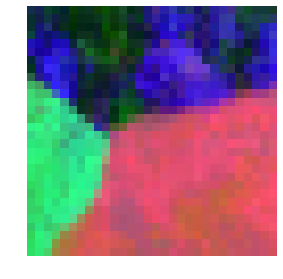

In [4]:
def draw_direct_color(features, ax):
    pca = PCA(n_components=3)
    X = pca.fit_transform(features)
    pca_range = [X.min(axis=0), X.max(axis=0)]
    X = (X - pca_range[0]) / (pca_range[1] - pca_range[0])
    Z = np.zeros((img_shape[0], img_shape[1], 3))
    Z[:, :, 0] = X[:, 0].reshape(img_shape)
    Z[:, :, 1] = X[:, 1].reshape(img_shape)
    Z[:, :, 2] = X[:, 2].reshape(img_shape)
    img = Z[::-1, :, :]
    ax.imshow(img, aspect=aspect_ratio)
    return img

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))
f = features[0]
img_dc = draw_direct_color(f, ax)
ax.axis('off')
plt.tight_layout()
# fig.savefig("img/C5_Direct_Color.pdf", dpi=300)

## Clustering
The normal clustering + labeling

train and score: 0.04487967491149902
Silhouette Score = 0.4300280594471625, Calinski-Harabaz Score = 585.1930033522848


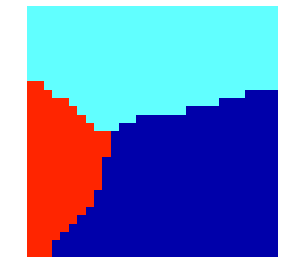

In [20]:
dataset = 0
ae_model = ae_models[dataset]
samples = features[dataset]

mPCA = None
K = 3
N = samples.shape[0]

model = KMeansModel()
if mPCA is not None and mPCA < samples.shape[1]:
    pca = PCA(n_components=mPCA)
    preprocessors = [pca]
else:
    preprocessors=[]

t0 = time.time()
if N > 6400:
    print("To many feature vectors, pick 6400 samples to train clustering")
    training_set = samples[np.random.choice(np.arange(N), 6400)]
else:
    training_set = samples
model.train(training_set, n_clusters=K, preprocessors=preprocessors)
scores = np.array(model.score(samples))
print("train and score:", time.time() - t0)

silhouette = model.compute_silhouette_score(samples)
calinski = model.compute_calinski_harabaz_score(samples)
print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

fig, ax = plt.subplots(ncols=1, nrows=1)

Z = model.color_by_pca(scores.reshape(img_shape), scaling='centroids')
ax.imshow(Z[::-1, :, :], aspect=aspect_ratio)
ax.axis('off')
plt.tight_layout()
# fig.savefig("img/C5_3.pdf", dpi=300)

In [21]:
img_k3 = Z[::-1, :, :]

## Indexing Labeler

Requires SEQ file(s)

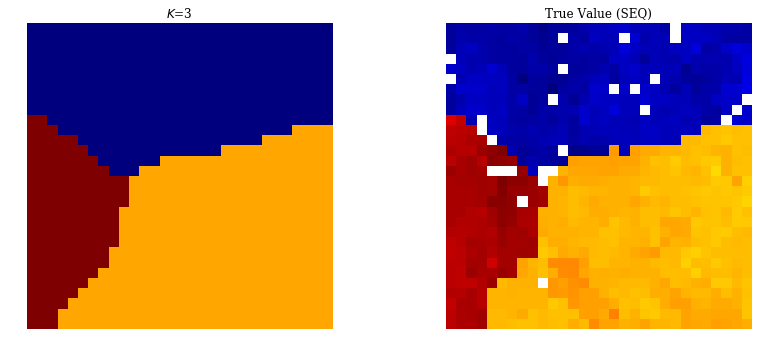

In [22]:
Z = read_seq(seqs[0])
vmax, vmin = Z.max(), Z.min()
seqfiles = [os.path.join("seq", seq+".SEQ") for seq in seqs]
labler = SeqLabeler(seqfiles, nidx_thres=10)
Z_seq = labler.Z_map()
mask = np.where(np.isfinite(Z_seq))
vmin, vmax = Z_seq[mask].min(), Z_seq[mask].max()

Z = model.score_by_seqs(samples, seqfiles)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
ax[0].imshow(Z[::-1, :], cmap='jet', aspect=1)
ax[0].axis('off')
ax[0].set_title(r'$K$=%d' % K, fontsize=12)
ax[1].imshow(Z_seq[::-1, :], cmap='jet', aspect=1)
ax[1].axis('off')
ax[1].set_title(r'True Value (SEQ)', fontsize=12)
plt.tight_layout()

In [23]:
img_seq_k3=Z[::-1, :]
#img_seq=Z_seq[::-1, :]

# Silhouette Score & Calinski-Harabaz Score
Use Silhouette Score & Calinski-Harabaz Score to estimate number of "coarse" clusters.
Good for grain boundaries and phase boundaries.

In [9]:
from joblib import Parallel, delayed

dataset = -1
ae_model = ae_models[dataset]
samples = features[dataset]

Ks = np.arange(2, 20, 1)
SCs=[]
N = len(samples)

def sc_scores(K):
    print("K=", K)
    model = KMeansModel()
    pca = PCA(n_components=32)
    if N > 6400:
        print("To many feature vectors, pick 6400 samples to train clustering")
        training_set = samples[np.random.choice(np.arange(N), 6400)]
    else:
        training_set = samples
    model.train(training_set, n_clusters=K, preprocessors=preprocessors)
    silhouette = model.compute_silhouette_score(samples)
    calinski = model.compute_calinski_harabaz_score(samples)
    print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))
    return silhouette, calinski

with Parallel(n_jobs=-1, verbose=1) as parallel:
    SCs = parallel(delayed(sc_scores)(k) for k in Ks)
    SCs = np.array(SCs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   10.0s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   10.4s finished


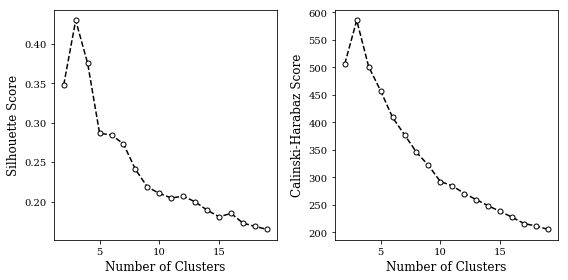

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(Ks, SCs[:, 0], 'o--k', markerfacecolor='w', markersize=5)
ax[0].set_xlabel(r'Number of Clusters', fontsize=12)
ax[0].set_ylabel(r'Silhouette Score', fontsize=12)

ax[1].plot(Ks, SCs[:, 1], 'o--k', markerfacecolor='w', markersize=5)
ax[1].set_xlabel(r'Number of Clusters', fontsize=12)
ax[1].set_ylabel(r'Calinski-Harabaz Score', fontsize=12)

plt.tight_layout()
fig.savefig("img/C5_SCH.pdf", dpi=300)

## Combine

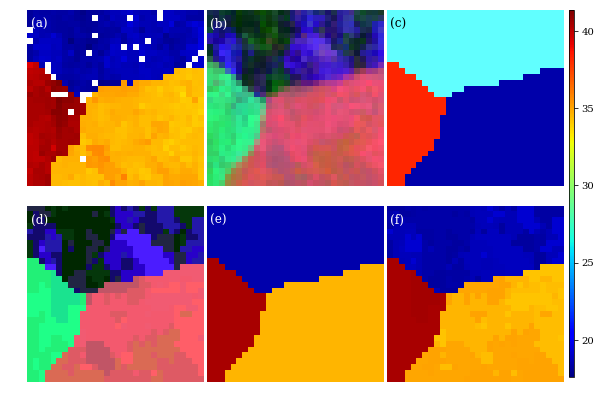

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

for ax in axes.flatten():
    ax.axis('off')
    
ax = axes[0, 0]
img = ax.imshow(img_seq, cmap='jet', vmin=vmin, vmax=vmax, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(a)', transform=ax.transAxes, fontsize=12, color='w')

ax = axes[0, 1]
ax.imshow(img_dc, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(b)', transform=ax.transAxes, fontsize=12, color='w')

ax = axes[0, 2]
ax.imshow(img_k3, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(c)', transform=ax.transAxes, fontsize=12, color='k')

ax = axes[1, 0]
ax.imshow(img_k16, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(d)', transform=ax.transAxes, fontsize=12, color='w')

ax = axes[1, 1]
ax.imshow(img_seq_k3, cmap='jet', vmin=vmin, vmax=vmax, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(e)', transform=ax.transAxes, fontsize=12, color='w')

ax = axes[1, 2]
ax.imshow(img_seq_k16, cmap='jet', vmin=vmin, vmax=vmax, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(f)', transform=ax.transAxes, fontsize=12, color='w')

fig.subplots_adjust(bottom=0, top=0.9, left=0, right=0.93, wspace=0.02, hspace=0.01)
cb_ax = fig.add_axes([0.94, 0.03, 0.01, 0.85])
cbar = fig.colorbar(img, cax=cb_ax)

fig.savefig("img/C5.pdf", dpi=300)